In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

from importlib import reload

import models
import plotting
import utils.dataloaders as dl
import traintest as tt
import adversarial as adv

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
preproc = dl.X_MNIST.view(3000,28,28).mean(dim=0)
preproc_std = torch.ones(28,28)
temp = dl.X_MNIST.view(3000,28,28).std(dim=0)
preproc_std[temp>.1] = temp[temp>.1]
base_model = models.LeNet(preproc=(preproc,preproc_std)).to(device)

In [5]:
lr = .01
momentum = .9

optimizer_base = optim.SGD(base_model.parameters(), lr=lr, momentum=momentum, weight_decay=0.005)
optimizer_base = optim.SGD(base_model.parameters(), lr=lr, momentum=momentum)
for epoch in range(10):
    optimizer_base.param_groups[0]['lr'] *= .8
    tt.train(base_model, device, dl.MNIST_train_loader, optimizer_base, epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.307098
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.207848
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.231446
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.145870
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.030179
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.055338
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.040603
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.024496
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.076479
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.055378
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.048278
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.013626
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.034736
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.007880
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.090586
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.008399
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.027729
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.009453
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.011508
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.010258
Train Epoch: 3 [2000

In [6]:
torch.save(base_model, 'SavedModels/base_model.pth')

In [3]:
base_model = torch.load('SavedModels/base_model.pth')
gmm = models.GMM(1000, 784)
gmm.find_solution(dl.X_MNIST, initialize=True, iterate=False, use_kmeans=False)
gmm_model = models.RobustModel(base_model, gmm, -7.).to(device)
torch.save(gmm_model, 'SavedModels/gmm_model.pth')

In [ ]:
pca_metric = models.PCAMetric(dl.X_MNIST)

base_model = torch.load('SavedModels/base_model.pth')
gmm_pca = models.GMM(300, 784, metric=pca_metric)
gmm_pca.find_solution(dl.X_MNIST, initialize=True, iterate=False, use_kmeans=False)
gmm_model_pca = models.RobustModel(base_model, gmm_pca, -4.5).to(device)
torch.save(gmm_model_pca, 'SavedModels/gmm_model_pca.pth')

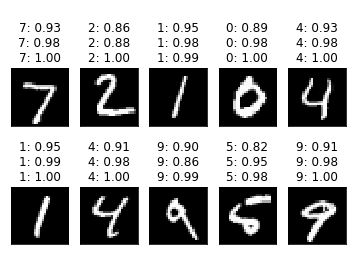

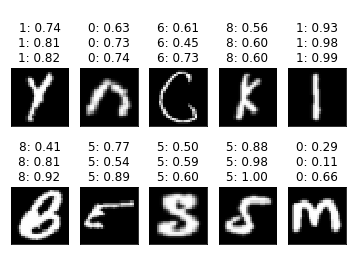

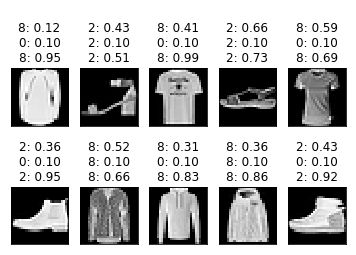




Test set: Average loss: 0.1386, Accuracy: 9853/10000 (99%), Ave. Confidence: 89%


Test set: Average loss: 0.0825, Accuracy: 9760/10000 (98%), Ave. Confidence: 94%


Test set: Average loss: 0.0353, Accuracy: 9880/10000 (99%), Ave. Confidence: 98%


Ave. Confidence: 63% Predicted: 71%


Ave. Confidence: 61% Predicted: 64%


Ave. Confidence: 79% Predicted: 88%



0.7870442269398616

In [98]:
#gmm_model.loglam.data = torch.tensor(-8., device=device)

data = enumerate(dl.MNIST_test_loader).__next__()[1][0]
y = gmm_model(data.to(device))
y2 = gmm_model_pca(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y, y2, y_base], data)

data = enumerate(dl.EMNIST_test_loader).__next__()[1][0]
y = gmm_model(data.to(device))
y2 = gmm_model_pca(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y, y2, y_base], data)

data = enumerate(dl.fashion_train_loader).__next__()[1][0]
y = gmm_model(data.to(device))
y2 = gmm_model_pca(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y, y2, y_base], data)

min_conf = .5
tt.test(gmm_model, device, dl.test_loader, min_conf=min_conf)
tt.test(gmm_model_pca, device, dl.test_loader, min_conf=min_conf)
tt.test(base_model, device, dl.test_loader, min_conf=min_conf)

tt.test_adv(gmm_model, device, dl.EMNIST_test_loader, min_conf=min_conf)
tt.test_adv(gmm_model_pca, device, dl.EMNIST_test_loader, min_conf=min_conf)
tt.test_adv(base_model, device, dl.EMNIST_test_loader, min_conf=min_conf)

In [41]:
data = enumerate(dl.test_loader).__next__()[1][0]

y = gmm_model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y, y_base], data)

In [92]:
gmm_model_pca.mm.logvar.data+=1.5

In [93]:
gmm_model_pca.mm.logvar.exp()

tensor([0.0336, 0.1836, 0.0856, 0.2446, 0.2448, 0.2726, 0.2170, 0.2527, 0.1033,
        0.1410, 0.2192, 0.1696, 0.2098, 0.2078, 0.1589, 0.0803, 0.2035, 0.2356,
        0.1536, 0.2628, 0.1367, 0.2005, 0.0061, 0.1547, 0.1054, 0.2392, 0.1848,
        0.1939, 0.0574, 0.2230, 0.2279, 0.1045, 0.0767, 0.0624, 0.1457, 0.2066,
        0.0985, 0.2401, 0.2103, 0.1898, 0.0612, 0.2050, 0.2493, 0.1667, 0.0780,
        0.1868, 0.1666, 0.2424, 0.3087, 0.0572, 0.2276, 0.1778, 0.2439, 0.1999,
        0.1506, 0.1372, 0.2321, 0.0061, 0.1265, 0.2312, 0.2477, 0.1417, 0.1390,
        0.2461, 0.2265, 0.1874, 0.0680, 0.2174, 0.1199, 0.0891, 0.1563, 0.2263,
        0.1979, 0.1996, 0.1492, 0.1954, 0.2001, 0.2904, 0.1784, 0.2057, 0.0946,
        0.1573, 0.1523, 0.1359, 0.1403, 0.1434, 0.1606, 0.2325, 0.0061, 0.1616,
        0.1766, 0.1730, 0.1866, 0.1662, 0.1917, 0.1543, 0.2146, 0.1402, 0.2291,
        0.2200, 0.1869, 0.2315, 0.2223, 0.0061, 0.2134, 0.0716, 0.0982, 0.1634,
        0.2545, 0.1865, 0.1704, 0.1972, 

In [99]:
torch.save(gmm_model_pca, 'SavedModels/gmm_model_pca.pth')

In [ ]:
def train_adv(model, device, train_loader, optimizer, epoch, verbose=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        
        #noise = generate_adv_noise(model, 0.1, batch_size=train_loader.batch_size)
        noise = adv.gen_adv_noise(model, 0.1, batch_size=10, device=device)
        noise = adv.gen_adv_noise(model, device, seed, epsilon=0.1, steps=40, step_size=0.01)
        output_adv = model(noise)
        
        loss = F.nll_loss(output, target) - output_adv.sum()/(10*train_loader.batch_size)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [37]:
def train_adv(model, device, train_loader, optimizer, noise_loader):
    model.train()
    for ((batch_idx, (data, target)), (_, (noise, _))) in zip(enumerate(train_loader),enumerate(noise_loader)):
        data, target = data.to(device), target.to(device)
        noise = noise.to(device)

        optimizer.zero_grad()
        output = model(data)
        data_adv = adv.gen_adv_noise(model, device, noise, epsilon=0.3, steps=40, step_size=0.01)
        output_adv = model(data_adv)
        
        loss = F.nll_loss(output, target) - output_adv.sum()/(10*train_loader.batch_size)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [58]:
lr = .00000001
momentum = .9

optimizer_base = optim.SGD(base_model.parameters(), lr=lr, momentum=momentum)
for epoch in range(1):
    optimizer_base.param_groups[0]['lr'] *= .8
    train_adv(base_model, device, dl.MNIST_train_loader, optimizer_base, dl.Noise_loader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.672061
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.640935
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.608258
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.588292
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.638180
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.674849


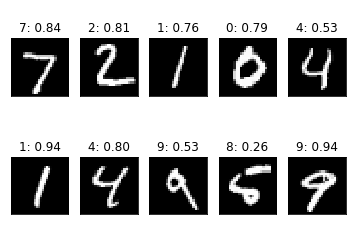

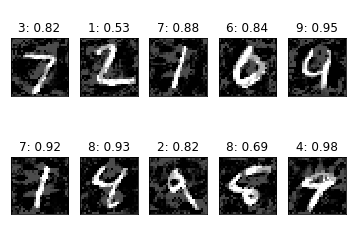

In [39]:
data, label = enumerate(dl.MNIST_test_loader).__next__()[1]

y_base = base_model(data.to(device))

plotting.plot_samples([y_base], data.detach().cpu())

data = adv.gen_adv_sample(base_model, device, data, label, epsilon=0.3, step_size=0.01)

y_base = base_model(data.to(device))

plotting.plot_samples([y_base], data.detach().cpu())

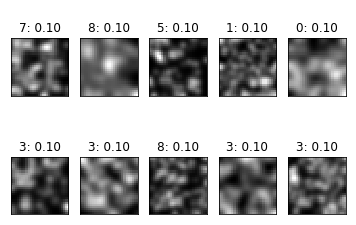

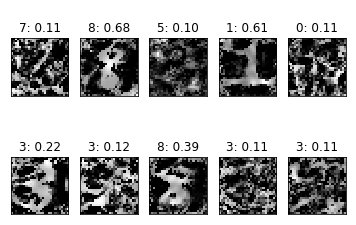

In [48]:
data = enumerate(dl.Noise_loader).__next__()[1][0]

y_base = base_model(data.to(device))

plotting.plot_samples([y_base], data.detach().cpu())

data2 = adv.gen_adv_noise(base_model, device, data, epsilon=0.3, step_size=0.01, steps=200)

y_base = base_model(data2.to(device))

plotting.plot_samples([y_base], data2.detach().cpu())

In [49]:
base_model(data2).exp()

tensor([[0.0978, 0.0989, 0.0989, 0.1022, 0.0996, 0.0977, 0.0976, 0.1111, 0.0964,
         0.1000],
        [0.0214, 0.0341, 0.0396, 0.0436, 0.0258, 0.0364, 0.0440, 0.0294, 0.6790,
         0.0467],
        [0.1006, 0.0998, 0.1001, 0.0993, 0.0994, 0.1017, 0.1006, 0.0998, 0.0991,
         0.0996],
        [0.0205, 0.6064, 0.0979, 0.0159, 0.0786, 0.0276, 0.0142, 0.0890, 0.0231,
         0.0268],
        [0.1109, 0.0983, 0.1036, 0.0967, 0.0979, 0.1009, 0.0982, 0.0971, 0.0976,
         0.0988],
        [0.0743, 0.0745, 0.0841, 0.2173, 0.0649, 0.1346, 0.0715, 0.0788, 0.1138,
         0.0861],
        [0.1012, 0.0943, 0.1020, 0.1237, 0.0891, 0.0979, 0.0879, 0.1012, 0.0989,
         0.1037],
        [0.0505, 0.0453, 0.1221, 0.0491, 0.0836, 0.0567, 0.0339, 0.1090, 0.3941,
         0.0558],
        [0.0989, 0.0987, 0.0992, 0.1089, 0.0981, 0.0985, 0.0980, 0.1022, 0.0984,
         0.0991],
        [0.1000, 0.0957, 0.0989, 0.1144, 0.1020, 0.0950, 0.0972, 0.1001, 0.0983,
         0.0986]], device='c

In [52]:
def forward(x):
    x = (x-base_model.preproc)/base_model.preproc_std
    x = F.relu(base_model.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(base_model.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*64)
    x = F.relu(base_model.fc1(x))
    return x

In [57]:
(forward(data2.to(device))>0).float().mean()

tensor(0.1307, device='cuda:0')